In snf01, I only looked for the presence of non-ref.
In this notebook, I will split it up into fixed/segregating sites for each pop, and how these sites segregate in other populations.
To make sure that the signal is less due to sequencing errors, I will also require each site to have a non-ref count of 2 for each.

In [1]:
%run ../scripts/notebook_settings.py

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")

In [3]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")
gt = allel.GenotypeArray(callset["calldata/GT"])

Filter for sites

In [4]:
ac = gt.count_alleles()[:] #Allele counts for each pos
flt = (ac.max_allele() == 1)  & (ac[:, :2].min(axis=1) > 1) #Filter for biallelic and presence of alternate
gf = gt.compress(flt, axis=0)
pos = (callset["variants/POS"][:]).compress(flt, axis=0)
print(len(gf), len(gt), len(gf)/len(gt))

2560187 2923212 0.8758129755898648


4 % are not biallelic and 7 % is fixed for one state (alternate?)

Picking the IDs to keep (using the clustering mentioned earlier)

In [5]:
c_dir = {}
for c in meta_data_samples.C_origin.unique():
    IDs = meta_data_samples.loc[(meta_data_samples.C_origin == c)
                                      & (meta_data_samples.Sex == "F")].callset_index.values
    if len(IDs) > 1:
        c_dir[c] = IDs
c_dir

{'Cynocephalus, Central Tanzania': array([  0,   1,  24,  25,  27,  35,  36,  37,  48,  61,  62,  63,  87,
        177, 186, 197, 201, 202, 204, 205, 206]),
 'Kindae, Zambia': array([  4,   5, 192, 213, 220, 221, 222, 223, 224]),
 'Hamadryas, Ethiopia': array([  7, 130, 132, 133, 140, 142]),
 'Anubis, Tanzania': array([ 10,  11,  14,  16,  17,  19,  20,  21,  22,  23,  30,  32,  33,
         49,  50,  51,  52,  54,  55,  56,  76,  79,  83,  84,  85,  90,
         91,  93,  95,  97,  99, 100, 101, 106, 107, 108, 109, 110, 112,
        114, 115, 117, 118]),
 'Cynocephalus, Western Tanzania': array([ 43, 104, 105]),
 'Papio, Senegal': array([64, 65, 66, 67, 68]),
 'Ursinus, Zambia': array([125, 126, 127]),
 'Anubis, Ethiopia': array([153, 156, 158, 162, 168, 169, 170, 176])}

Creating a dataframe with derived counts

In [6]:
df_cluster = pd.DataFrame()
df_cluster["pos"] = pos
for c in c_dir:
    print(c)
    IDs = c_dir[c]
    gt_c = gf.take(IDs, axis=1)
    ac = gt_c.count_alleles()
    df_cluster[c] = ac.take([1], axis=1) # Only containing derived
    print(ac.is_variant().sum())

Cynocephalus, Central Tanzania
864233
Kindae, Zambia
578411
Hamadryas, Ethiopia
355074
Anubis, Tanzania
650231
Cynocephalus, Western Tanzania
547103
Papio, Senegal
185075
Ursinus, Zambia
410758
Anubis, Ethiopia
310132


In [7]:
ac.take([1], axis=1)

array([[ 0],
       [ 0],
       [ 6],
       ...,
       [ 0],
       [ 0],
       [14]], dtype=int32)

In [8]:
df_cluster

,pos,"Cynocephalus, Central Tanzania","Kindae, Zambia","Hamadryas, Ethiopia","Anubis, Tanzania","Cynocephalus, Western Tanzania","Papio, Senegal","Ursinus, Zambia","Anubis, Ethiopia"
0,37,30,1,0,14,4,8,6,0
1,57,17,1,0,11,4,0,6,0
2,157,2,7,10,45,2,0,1,6
3,170,6,0,0,3,2,0,0,0
4,216,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2560182,143691503,0,0,0,0,0,0,0,0
2560183,143691509,0,0,0,0,0,0,0,0
2560184,143691526,0,0,0,0,0,0,0,0
2560185,143691548,0,0,0,0,0,0,0,0


For the first run, I will just look at anubis and hamadryas. Looking at cynocephalus and anubis will also be advisable

In [9]:
df_haa = df_cluster.take([0, 3, 4, 8],axis=1)

In [10]:
df_haa.loc[df_haa.pos < 200]

,pos,"Hamadryas, Ethiopia","Anubis, Tanzania","Anubis, Ethiopia"
0,37,0,14,0
1,57,0,11,0
2,157,10,45,6
3,170,0,3,0


Number of sites with the four different derived cases

In [11]:
(df_haa.iloc[:,1:] > 0).sum(axis=1).value_counts()

0    1657162
1     633946
3     143333
2     125746
dtype: int64

<AxesSubplot:ylabel='Count'>

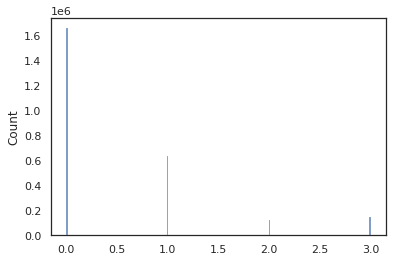

In [12]:
sns.histplot(x=(df_haa.iloc[:,1:] > 0).sum(axis=1))

In [13]:
df_haa_2_derived = df_haa.loc[(df_haa.iloc[:,1:] > 0).sum(axis=1) == 2]

In [14]:
print(len(df_haa_2_derived))
print((df_haa_2_derived["Hamadryas, Ethiopia"] == 0).sum())
print((df_haa_2_derived["Anubis, Tanzania"] == 0).sum())
print((df_haa_2_derived["Anubis, Ethiopia"] == 0).sum())

125746
50494
26554
48698


The above observation is surprising - it might be due to the higher number of samples from Anubis in Tanzania.
Trying to restrict it to more than 2

In [15]:
df_haa_2_derived = df_haa.loc[(df_haa.iloc[:,1:] > 1).sum(axis=1) == 2]

In [16]:
print(len(df_haa_2_derived))
print((df_haa_2_derived["Hamadryas, Ethiopia"] == 0).sum())
print((df_haa_2_derived["Anubis, Tanzania"] == 0).sum())
print((df_haa_2_derived["Anubis, Ethiopia"] == 0).sum())

110597
35532
13526
37950


In [17]:
df_haa_2_derived.loc[df_haa_2_derived["Anubis, Ethiopia"] == 0]

,pos,"Hamadryas, Ethiopia","Anubis, Tanzania","Anubis, Ethiopia"
364,10674,4,14,0
398,11544,6,24,0
409,11937,6,21,0
414,12062,6,14,0
436,12731,6,14,0
...,...,...,...,...
2559732,143661822,12,34,0
2560016,143677321,3,36,0
2560046,143678390,5,2,0
2560119,143683013,3,5,0


A generalized chunk to handle this

In [18]:
window_size = 100000
donor1 = "Cynocephalus, Central Tanzania"
donor2 = "Anubis, Ethiopia"
recipient = "Anubis, Tanzania"
df_three_way = df_cluster.filter(items = ["pos", donor1, donor2, recipient])
df_2_derived = df_three_way.loc[(df_three_way.iloc[:,1:] > 0).sum(axis=1) == 2]
windows = range(0, df_haa_2_derived.iloc[-1:].pos.values[0], 100000)
windows[-1]
df_derived_stats = pd.DataFrame()
w_l = []
d1 = []
d2 = []
for w_s in windows:
    df_w = df_2_derived.loc[(df_2_derived.pos > w_s)
                         & (df_2_derived.pos < w_s+window_size)]
    mix2 = df_w.loc[df_w[donor1] == 0][recipient].sum()/len(c_dir[recipient])
    mix1 = df_w.loc[df_w[donor2] == 0][recipient].sum()/len(c_dir[recipient])
    if mix1 == 0 and mix2 == 0:
        continue
    w_l.append(w_s)
    d1.append(mix1/(mix1+mix2))
    d2.append(mix2/(mix1+mix2))
df_derived_stats["start"] = w_l
df_derived_stats["donor1"] = d1
df_derived_stats[donor2] = d2
df_derived_stats["chrom"] = "chrX"
df_derived_stats["pop"] = recipient

In [19]:
df_derived_stats

,start,donor1,"Anubis, Ethiopia",chrom,pop
0,0,0.563795,0.436205,chrX,"Anubis, Tanzania"
1,100000,0.700739,0.299261,chrX,"Anubis, Tanzania"
2,200000,0.523746,0.476254,chrX,"Anubis, Tanzania"
3,300000,0.551188,0.448812,chrX,"Anubis, Tanzania"
4,400000,0.553600,0.446400,chrX,"Anubis, Tanzania"
...,...,...,...,...,...
1432,143200000,0.813210,0.186790,chrX,"Anubis, Tanzania"
1433,143300000,0.895397,0.104603,chrX,"Anubis, Tanzania"
1434,143400000,0.847188,0.152812,chrX,"Anubis, Tanzania"
1435,143500000,0.832847,0.167153,chrX,"Anubis, Tanzania"


<AxesSubplot:xlabel='donor1', ylabel='Count'>

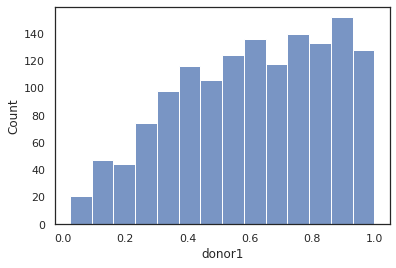

In [20]:
sns.histplot(data=df_derived_stats, x="donor1")

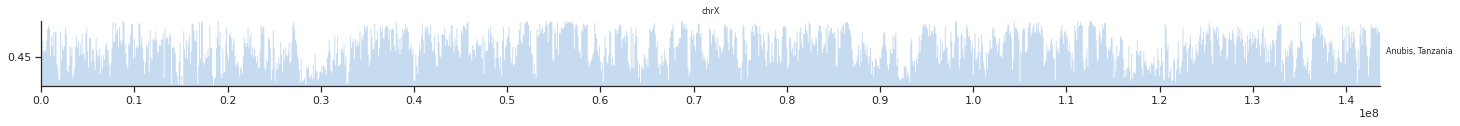

In [21]:
fig = horizonplot(df_derived_stats, "donor1", width=1, col='chrom', row='pop', size=2, aspect=10, cut=1)

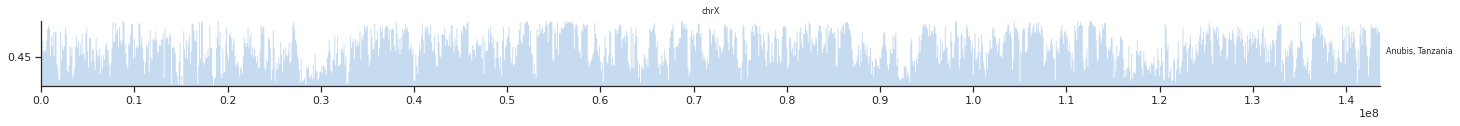

In [22]:
fig = horizonplot(df_derived_stats, "donor1", width=1, col='chrom', row='pop', size=2, aspect=10, cut=1)

<AxesSubplot:xlabel='donor1', ylabel='Count'>

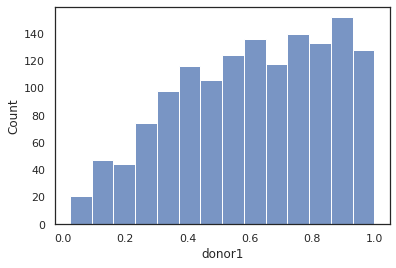

In [23]:
sns.histplot(data=df_derived_stats, x = "donor1")

In [24]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chr8"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")
gt = allel.GenotypeArray(callset["calldata/GT"])

In [25]:
ac = gt.count_alleles()[:] #Allele counts for each pos
flt = (ac.max_allele() == 1)  & (ac[:, :2].min(axis=1) > 1) #Filter for biallelic and presence of alternate
gf = gt.compress(flt, axis=0)
pos = (callset["variants/POS"][:]).compress(flt, axis=0)
print(len(gf), len(gt), len(gf)/len(gt))

4022831 4992526 0.8057706659915241


In [26]:
df_cluster = pd.DataFrame()
df_cluster["pos"] = pos
for c in c_dir:
    print(c)
    IDs = c_dir[c]
    gt_c = gf.take(IDs, axis=1)
    ac = gt_c.count_alleles()
    df_cluster[c] = ac.take([1], axis=1) # Only containing derived
    print(ac.is_variant().sum())

Cynocephalus, Central Tanzania
1613853
Kindae, Zambia
1316040
Hamadryas, Ethiopia
731905
Anubis, Tanzania
1397503
Cynocephalus, Western Tanzania
1000197
Papio, Senegal
402140
Ursinus, Zambia
809635
Anubis, Ethiopia
759001


In [47]:
window_size = 1000000
donor1 = "Kindae, Zambia" # "Cynocephalus, Western Tanzania" #"Hamadryas, Ethiopia" #"Papio, Senegal" # "Cynocephalus, Central Tanzania"
donor2 = "Anubis, Ethiopia"
recipient = "Anubis, Tanzania"
df_three_way = df_cluster.filter(items = ["pos", donor1, donor2, recipient])
df_2_derived = df_three_way.loc[(df_three_way.iloc[:,1:] > 0).sum(axis=1) == 2]
windows = range(0, df_haa_2_derived.iloc[-1:].pos.values[0], 100000)
windows[-1]
df_derived_stats = pd.DataFrame()
w_l = []
d1 = []
d2 = []
for w_s in windows:
    df_w = df_2_derived.loc[(df_2_derived.pos > w_s)
                         & (df_2_derived.pos < w_s+window_size)]
    mix2 = df_w.loc[df_w[donor1] == 0][recipient].sum()/len(c_dir[recipient])
    mix1 = df_w.loc[df_w[donor2] == 0][recipient].sum()/len(c_dir[recipient])
    if mix1 == 0 and mix2 == 0:
        continue
    w_l.append(w_s)
    d1.append(mix1/(mix1+mix2))
    d2.append(mix2/(mix1+mix2))
df_derived_stats["start"] = w_l
df_derived_stats["donor1"] = d1
df_derived_stats[donor2] = d2
df_derived_stats["chrom"] = "chr7"
df_derived_stats["pop"] = recipient

In [48]:
df_derived_stats["donor1"].mean()

0.3866230282080667

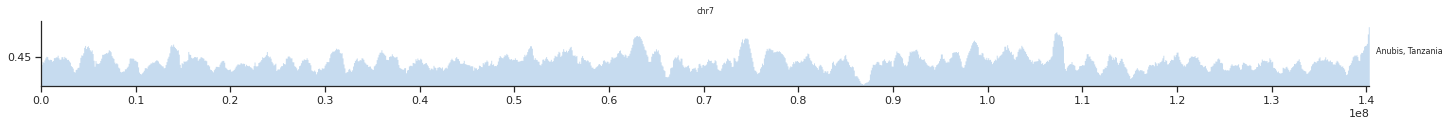

In [49]:
fig = horizonplot(df_derived_stats, "donor1", width=1, col='chrom', row='pop', size=2, aspect=10, cut=1)

Testing code - remove later

In [28]:
df_2_derived.loc[df_2_derived[donor1] == 0][recipient].sum()/len(c_dir[recipient])

47797.11627906977

In [29]:
df_2_derived.loc[df_2_derived[donor1] == 0][recipient]

48          1
134        19
242         4
395         7
459        17
           ..
4022666    12
4022671    28
4022714    11
4022746     9
4022775     7
Name: Anubis, Tanzania, Length: 148780, dtype: int32